# Statistical and Neural Forecasting methods
> In this notebook, you will make forecasts for the M5 dataset choosing the best model for each time series using cross validation.

In time series forecasting and analysis, it can be challenging to determine which model is best suited for a particular group of series. This decision often relies on intuition, which may not always align with reality.

In this tutorial, we will demonstrate a robust approach for selecting models for groups of series using the M5 benchmark dataset. We will train the following models:

- Baseline models: `SeasonalNaive` and `HistoricAverage`
- Intermittent models: `CrostonOptimized`, `IMAPA`, and `ADIDA`
- State Space Models: `AutoETS`
- Deep Learning: Transformers (`AutoTFT`) and Neural Networks (`AutoNHITS`) (from [NeuralForecast](https://github.com/Nixtla/neuralforecast))

By using the Nixtla libraries, we will be able to make more informed decisions on which models to use for specific groups of series in our dataset.

Outline:

* Read data
* Forecast the next 28 days using statiscal and deep learning methods
* Evaluate the models perfomance on different Windows
* Choose the best model for a group of series
* Filter the best possible forecast 

::: {.callout-warning collapse="false"}
This tutorial was originally executed using a `c5d.24xlarge` EC2 instance.
:::

## Installing Libraries

In [ ]:
%%capture
!pip install statsforecast datasetforecast s3fs pyarrow

## Download and prepare data

The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series. 

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('s3://m5-benchmarks/data/train/target.parquet')


#Feature: The Nixtlaverse takes as input a df with id's, timestamps and values.
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

For simplicity sake we will keep just one category

In [ ]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")')

Y_df['unique_id'] = Y_df['unique_id'].astype(str)

# Basic Plotting

Plot some series using the plot method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic [EDA](https://nixtla.github.io/statsforecast/core.html#statsforecast.plot).


In [ ]:
from statsforecast import StatsForecast

/home/ubuntu/fede/statsforecast/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


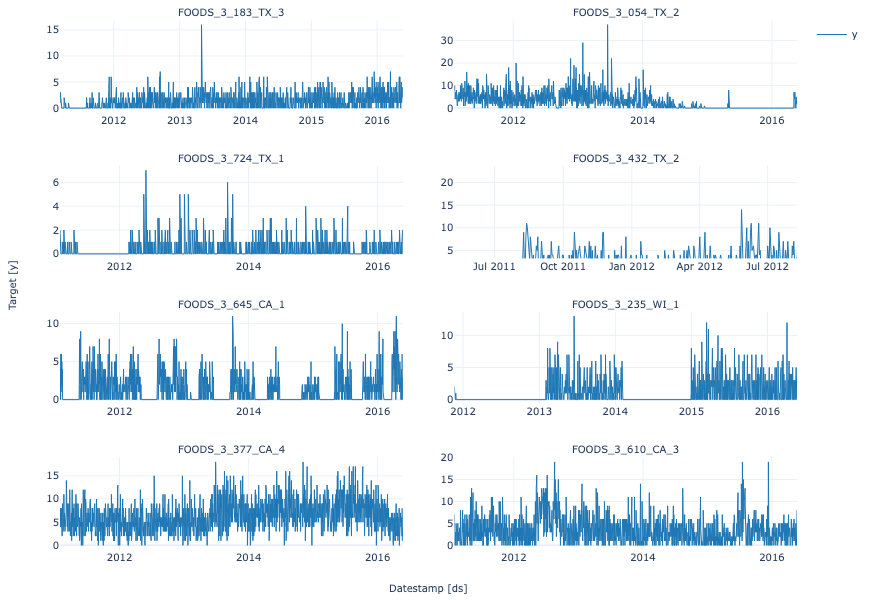

In [ ]:
# Feature: plot random series for EDA
StatsForecast.plot(Y_df)

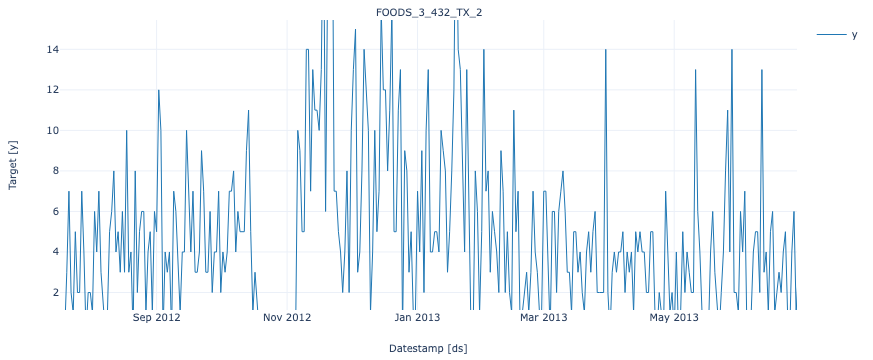

In [ ]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_432_TX_2"])

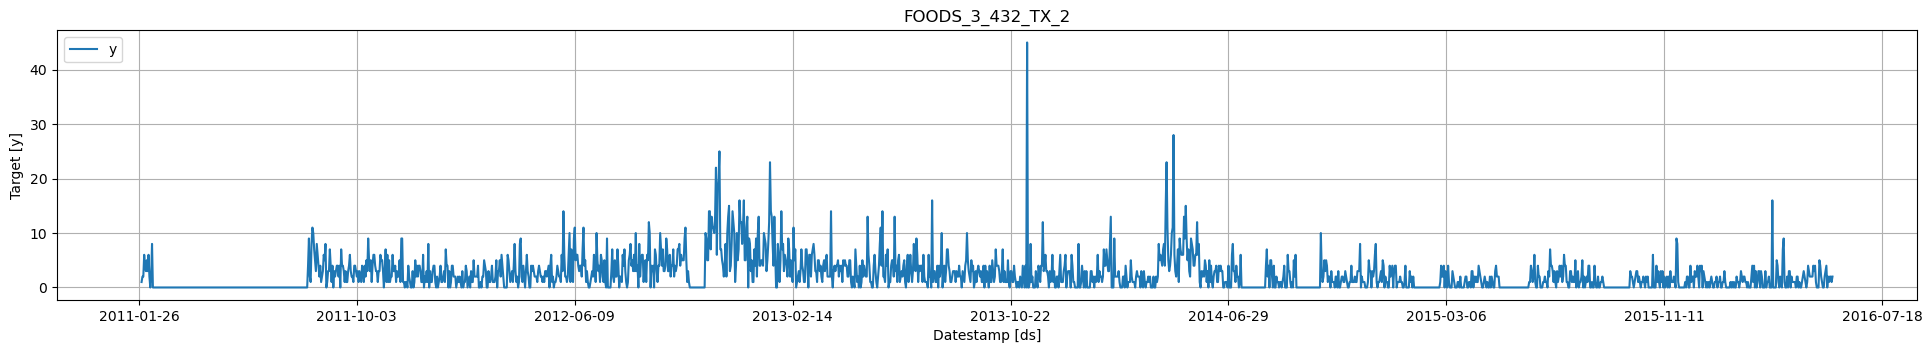

In [ ]:
# Feature: plot groups of series for EDA
StatsForecast.plot(Y_df, unique_ids=["FOODS_3_432_TX_2"], engine ='matplotlib')

# Scalable Forecast 

## StatsForecast

`StatsForecast` offers a collection of popular univariate time series forecasting models optimized for high performance and scalability.

Features:

* Collection of local models. 
* Simple: training, forecasting and backtesting of many models in a few lines
* Optimized for speed
* Scales horizontally with Spark, Dask, Ray



`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

In [ ]:
# Import models
from statsforecast.models import (
    SeasonalNaive,
    Naive,
    HistoricAverage,
    CrostonOptimized,
    ADIDA,
    IMAPA,
    AutoETS
)

We fit the models by instantiating a new StatsForecast object with the following parameters:

- `models`: a list of models. Select the models you want from models and import them.
- `freq`: a string indicating the frequency of the data. (See panda’s available frequencies.)
- `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.
- `fallback_model`: a model to be used if a model fails.
Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [ ]:
# Instantiate statsforecast class
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1,
)

The forecast method takes two arguments: forecasts next h (horizon) and level.

- `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

In [ ]:
from time import time

init = time()
fcst_df = sf.forecast(df=Y_df, h=28, level=[90])
end = time()
print(f'Forecast Minutes: {(end - init) / 60}')

Forecast Minutes: 2.4677709062894184


In [ ]:
fcst_df.head()

ds  SeasonalNaive  SeasonalNaive-lo-90  \
unique_id                                                         
FOODS_3_001_CA_1 2016-05-23            1.0            -2.847174   
FOODS_3_001_CA_1 2016-05-24            0.0            -3.847174   
FOODS_3_001_CA_1 2016-05-25            0.0            -3.847174   
FOODS_3_001_CA_1 2016-05-26            1.0            -2.847174   
FOODS_3_001_CA_1 2016-05-27            0.0            -3.847174   

                  SeasonalNaive-hi-90  Naive  Naive-lo-90  Naive-hi-90  \
unique_id                                                                
FOODS_3_001_CA_1             4.847174    2.0     0.098363     3.901637   
FOODS_3_001_CA_1             3.847174    2.0    -0.689321     4.689321   
FOODS_3_001_CA_1             3.847174    2.0    -1.293732     5.293732   
FOODS_3_001_CA_1             4.847174    2.0    -1.803274     5.803274   
FOODS_3_001_CA_1             3.847174    2.0    -2.252190     6.252190   

                  HistoricAverage  HistoricAverage-lo-90  \
unique_id                                                  
FOODS_3_001_CA_1         0.448738              -1.009579   
FOODS_3_001_CA_1         0.448738              -1.009579   
FOODS_3_001_CA_1         0.448738              -1.009579   
FOODS_3_001_CA_1         0.448738              -1.009579   
FOODS_3_001_CA_1         0.448738              -1.009579   

                  HistoricAverage-hi-90  CrostonOptimized     ADIDA     IMAPA  \
unique_id                                                                       
FOODS_3_001_CA_1               1.907055          0.345192  0.345477  0.347249   
FOODS_3_001_CA_1               1.907055          0.345192  0.345477  0.347249   
FOODS_3_001_CA_1               1.907055          0.345192  0.345477  0.347249   
FOODS_3_001_CA_1               1.907055          0.345192  0.345477  0.347249   
FOODS_3_001_CA_1               1.907055          0.345192  0.345477  0.347249   

                   AutoETS  AutoETS-lo-90  AutoETS-hi-90  
unique_id                                                 
FOODS_3_001_CA_1  0.381414      -1.028122       1.790950  
FOODS_3_001_CA_1  0.286933      -1.124136       1.698003  
FOODS_3_001_CA_1  0.334987      -1.077614       1.747588  
FOODS_3_001_CA_1  0.186851      -1.227280       1.600982  
FOODS_3_001_CA_1  0.308112      -1.107548       1.723771

### Feature Support for distibuted engines

In [ ]:
# You can use a ray, spark or dask cluster to
# scale your forecasting task
#from statsforecast.distributed.fugue import FugueBackend

#backend = FugueBackend(spark, {'fugue.spark.use_pandas_udf':True})

#sf_cluster = StatsForecast(
#    models=models, 
#    freq='D', 
#    n_jobs=-1,
#    backend=backend
#)
#

## NeuralForecast

`NeuralForecast` offers a large collection of neural forecasting models focused on their usability, and robustness. The models range from classic networks like MLP, RNNs to novel proven contributions like NBEATS, NHITS, TFT and other architectures.

Features:
* Collection of global models. 
* Simple: training, forecasting and backtesing of many models in a few lines. 
* GPU Support

This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train NeuralForecast](https://colab.research.google.com/drive/1VdV2g7MZCecISXAin_uB4HF8XrgMzubm#scrollTo=ilT6RaEZn6MN).


In [ ]:
# Read the results from Colab
fcst_nf_df = pd.read_parquet('s3://m5-benchmarks/data/forecast-nf.parquet')

In [ ]:
fcst_nf_df.head()

unique_id         ds  AutoNHITS  AutoNHITS-lo-90  AutoNHITS-hi-90  \
0  FOODS_3_001_CA_1 2016-05-23        0.0              0.0              2.0   
1  FOODS_3_001_CA_1 2016-05-24        0.0              0.0              2.0   
2  FOODS_3_001_CA_1 2016-05-25        0.0              0.0              2.0   
3  FOODS_3_001_CA_1 2016-05-26        0.0              0.0              2.0   
4  FOODS_3_001_CA_1 2016-05-27        0.0              0.0              2.0   

   AutoTFT  AutoTFT-lo-90  AutoTFT-hi-90  
0      0.0            0.0            2.0  
1      0.0            0.0            2.0  
2      0.0            0.0            1.0  
3      0.0            0.0            2.0  
4      0.0            0.0            2.0

In [ ]:
# Merge the two dataframes. 
fcst_df = fcst_df.merge(fcst_nf_df, how='left', on=['unique_id', 'ds'])

In [ ]:
fcst_df.head()

unique_id         ds  SeasonalNaive  SeasonalNaive-lo-90  \
0  FOODS_3_001_CA_1 2016-05-23            1.0            -2.847174   
1  FOODS_3_001_CA_1 2016-05-24            0.0            -3.847174   
2  FOODS_3_001_CA_1 2016-05-25            0.0            -3.847174   
3  FOODS_3_001_CA_1 2016-05-26            1.0            -2.847174   
4  FOODS_3_001_CA_1 2016-05-27            0.0            -3.847174   

   SeasonalNaive-hi-90  Naive  Naive-lo-90  Naive-hi-90  HistoricAverage  \
0             4.847174    2.0     0.098363     3.901637         0.448738   
1             3.847174    2.0    -0.689321     4.689321         0.448738   
2             3.847174    2.0    -1.293732     5.293732         0.448738   
3             4.847174    2.0    -1.803274     5.803274         0.448738   
4             3.847174    2.0    -2.252190     6.252190         0.448738   

   HistoricAverage-lo-90  ...     IMAPA   AutoETS  AutoETS-lo-90  \
0              -1.009579  ...  0.347249  0.381414      -1.028122   
1              -1.009579  ...  0.347249  0.286933      -1.124136   
2              -1.009579  ...  0.347249  0.334987      -1.077614   
3              -1.009579  ...  0.347249  0.186851      -1.227280   
4              -1.009579  ...  0.347249  0.308112      -1.107548   

   AutoETS-hi-90  AutoNHITS  AutoNHITS-lo-90  AutoNHITS-hi-90  AutoTFT  \
0       1.790950        0.0              0.0              2.0      0.0   
1       1.698003        0.0              0.0              2.0      0.0   
2       1.747588        0.0              0.0              2.0      0.0   
3       1.600982        0.0              0.0              2.0      0.0   
4       1.723771        0.0              0.0              2.0      0.0   

   AutoTFT-lo-90  AutoTFT-hi-90  
0            0.0            2.0  
1            0.0            2.0  
2            0.0            1.0  
3            0.0            2.0  
4            0.0            2.0  

[5 rows x 23 columns]

## Forecast plots

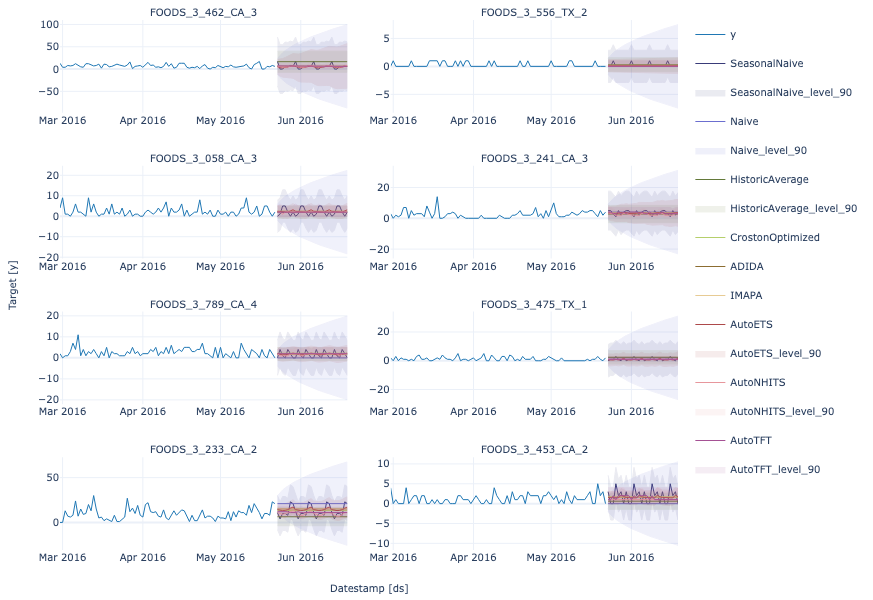

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

Use the plot function to explore models and ID's

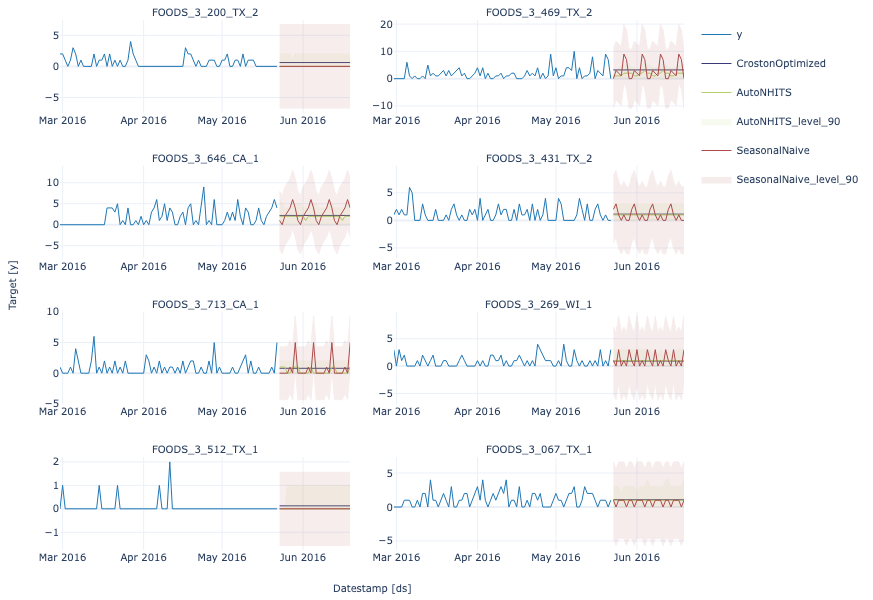

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3, 
        models=['CrostonOptimized', 'AutoNHITS', 'SeasonalNaive'])

# Validate Model's Performance

Both `StatsForecast` and `NeuralForecast` offer out of the box cross validation for time series.


![From the course of Modern Forecasting in Practice](../imgs/cv-sphere.png)

## StatsForecast

The `cross_validation` method from the `StatsForecast` class takes the following arguments.

- `df`: training data frame
- `h` (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead.
- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

/home/ubuntu/fede/statsforecast/statsforecast/ets.py:1039: RuntimeWarning:

divide by zero encountered in divide



CV Minutes: 6.015557058652242


The crossvaldation_df object is a new data frame that includes the following columns:

- `unique_id` index: (If you dont like working with index just run forecasts_cv_df.resetindex())
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_df.head()

ds     cutoff    y  SeasonalNaive  \
unique_id                                                    
FOODS_3_001_CA_1 2016-02-29 2016-02-28  0.0            2.0   
FOODS_3_001_CA_1 2016-03-01 2016-02-28  1.0            0.0   
FOODS_3_001_CA_1 2016-03-02 2016-02-28  1.0            0.0   
FOODS_3_001_CA_1 2016-03-03 2016-02-28  0.0            1.0   
FOODS_3_001_CA_1 2016-03-04 2016-02-28  0.0            1.0   

                  SeasonalNaive-lo-90  SeasonalNaive-hi-90  Naive  \
unique_id                                                           
FOODS_3_001_CA_1            -1.878885             5.878885    0.0   
FOODS_3_001_CA_1            -3.878885             3.878885    0.0   
FOODS_3_001_CA_1            -3.878885             3.878885    0.0   
FOODS_3_001_CA_1            -2.878885             4.878885    0.0   
FOODS_3_001_CA_1            -2.878885             4.878885    0.0   

                  Naive-lo-90  Naive-hi-90  HistoricAverage  \
unique_id                                                     
FOODS_3_001_CA_1    -1.917011     1.917011         0.449111   
FOODS_3_001_CA_1    -2.711064     2.711064         0.449111   
FOODS_3_001_CA_1    -3.320361     3.320361         0.449111   
FOODS_3_001_CA_1    -3.834023     3.834023         0.449111   
FOODS_3_001_CA_1    -4.286568     4.286568         0.449111   

                  HistoricAverage-lo-90  HistoricAverage-hi-90  \
unique_id                                                        
FOODS_3_001_CA_1              -1.021813               1.920036   
FOODS_3_001_CA_1              -1.021813               1.920036   
FOODS_3_001_CA_1              -1.021813               1.920036   
FOODS_3_001_CA_1              -1.021813               1.920036   
FOODS_3_001_CA_1              -1.021813               1.920036   

                  CrostonOptimized     ADIDA     IMAPA   AutoETS  \
unique_id                                                          
FOODS_3_001_CA_1          0.618472  0.618375  0.617998  0.655286   
FOODS_3_001_CA_1          0.618472  0.618375  0.617998  0.568595   
FOODS_3_001_CA_1          0.618472  0.618375  0.617998  0.618805   
FOODS_3_001_CA_1          0.618472  0.618375  0.617998  0.455891   
FOODS_3_001_CA_1          0.618472  0.618375  0.617998  0.591197   

                  AutoETS-lo-90  AutoETS-hi-90  
unique_id                                       
FOODS_3_001_CA_1      -0.765731       2.076302  
FOODS_3_001_CA_1      -0.853966       1.991155  
FOODS_3_001_CA_1      -0.805298       2.042908  
FOODS_3_001_CA_1      -0.969753       1.881534  
FOODS_3_001_CA_1      -0.835987       2.018380

## NeuralForecast

This machine doesn't have GPU, but Google Colabs offers some for free. 

Using [Colab's GPU to train Neural Forecast](https://colab.research.google.com/drive/1VdV2g7MZCecISXAin_uB4HF8XrgMzubm#scrollTo=ilT6RaEZn6MN).


In [ ]:
cv_nf_df = pd.read_parquet('s3://m5-benchmarks/data/cross-validation-nf.parquet')

In [ ]:
cv_nf_df.head()

unique_id         ds     cutoff  AutoNHITS  AutoNHITS-lo-90  \
0  FOODS_3_001_CA_1 2016-02-29 2016-02-28        0.0              0.0   
1  FOODS_3_001_CA_1 2016-03-01 2016-02-28        0.0              0.0   
2  FOODS_3_001_CA_1 2016-03-02 2016-02-28        0.0              0.0   
3  FOODS_3_001_CA_1 2016-03-03 2016-02-28        0.0              0.0   
4  FOODS_3_001_CA_1 2016-03-04 2016-02-28        0.0              0.0   

   AutoNHITS-hi-90  AutoTFT  AutoTFT-lo-90  AutoTFT-hi-90    y  
0              2.0      1.0            0.0            2.0  0.0  
1              2.0      1.0            0.0            2.0  1.0  
2              2.0      1.0            0.0            2.0  1.0  
3              2.0      1.0            0.0            2.0  0.0  
4              2.0      1.0            0.0            2.0  0.0

## Merge cross validation forecasts

In [ ]:
cv_df = cv_df.merge(cv_nf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

## Plots CV

In [ ]:
cutoffs = cv_df['cutoff'].unique()

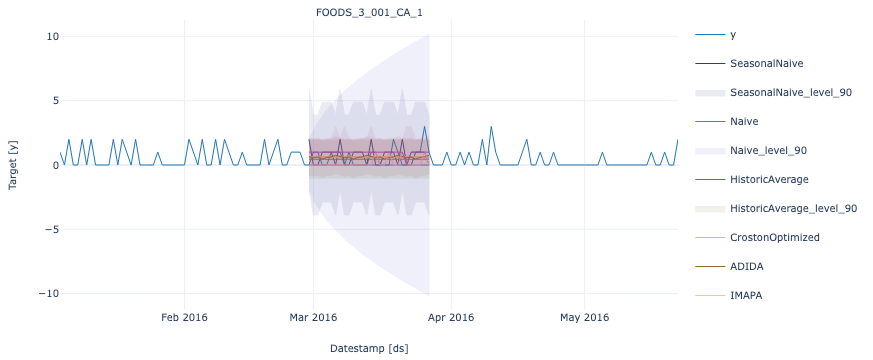

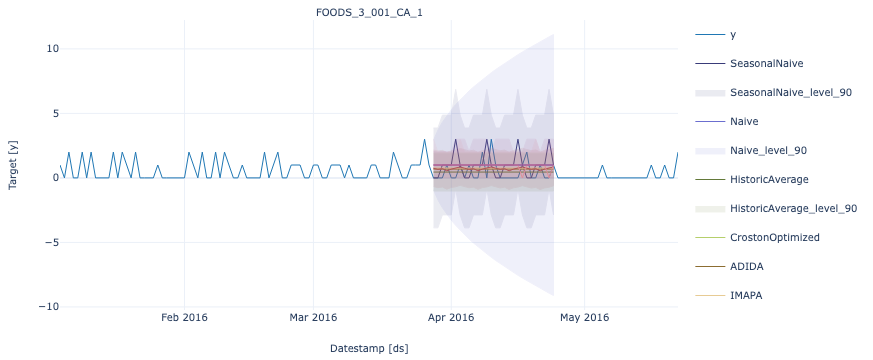

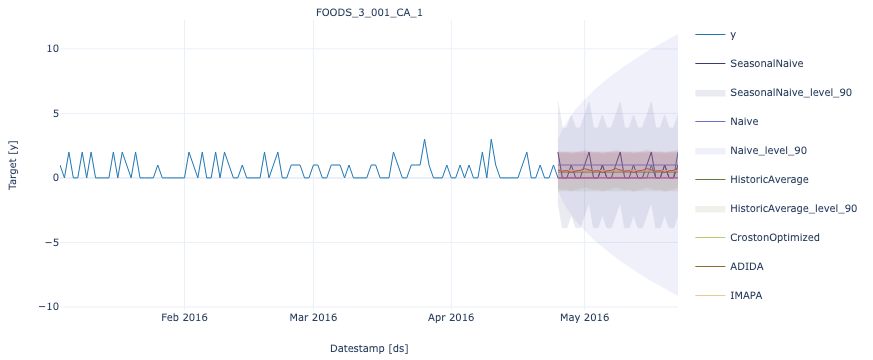

In [ ]:
for cutoff in cutoffs:
    sf.plot(Y_df, 
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
            max_insample_length=28 * 5, 
            unique_ids=['FOODS_3_001_CA_1'])

### Aggregate Demand

In [ ]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

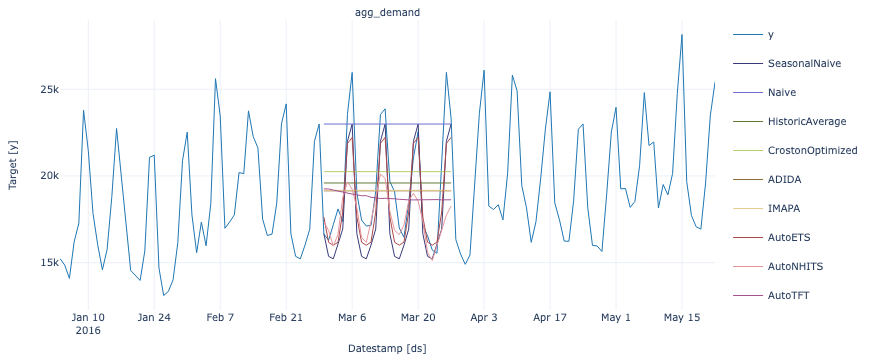

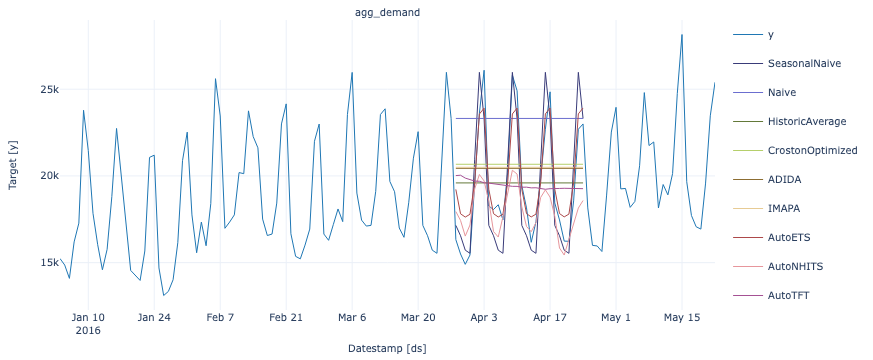

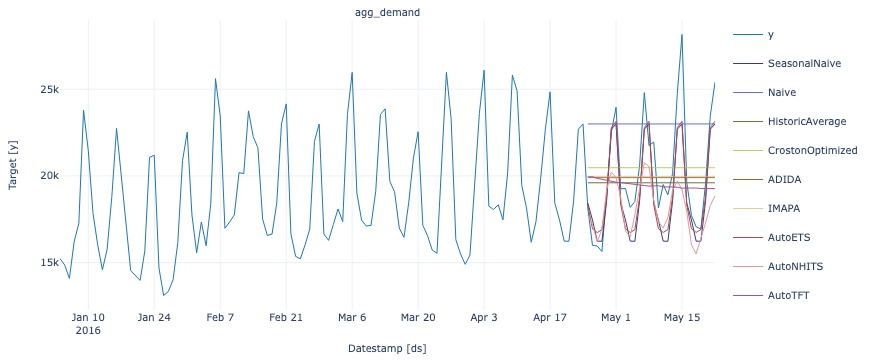

In [ ]:
for cutoff in cutoffs:
    sf.plot(agg_Y_df, 
            agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=28 * 5)

## Evaluation per series and CV window

In this section we will evaluate the performance of each model for each time series and each cross validation window. Since we have many combinations, we will use `dask` to parallelize the evaluation. The parallelization will be done using `fugue`.

In [ ]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape

The `evaluate` function receives a unique combination of a time series and a window, and calculates different `metrics` for each model in `df`.

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

Let's cleate a `dask` client.

In [ ]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

/home/ubuntu/miniconda/envs/statsforecast/lib/python3.10/site-packages/distributed/dashboard/core.py:20: UserWarning:


Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.0.2.
Continuing without the dashboard.

/home/ubuntu/miniconda/envs/statsforecast/lib/python3.10/site-packages/distributed/node.py:183: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37415 instead



The `transform` function takes the `evaluate` functions and applies it to each combination of time series (`unique_id`) and cross validation window (`cutoff`) using the `dask` client we created before.

In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine=engine, #"dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [ ]:
evaluation_df.head()

unique_id      cutoff metric  SeasonalNaive      Naive  \
0  FOODS_3_018_CA_3  2016-03-27    mse       2.750000   2.035714   
1  FOODS_3_018_CA_3  2016-03-27    mae       1.250000   1.035714   
2  FOODS_3_018_CA_3  2016-03-27  smape      99.523811  84.761902   
3  FOODS_3_021_TX_1  2016-03-27    mse       1.000000   4.857143   
4  FOODS_3_021_TX_1  2016-03-27    mae       0.714286   2.000000   

   HistoricAverage  CrostonOptimized      ADIDA      IMAPA    AutoETS  \
0         2.257121          1.965976   1.959041   1.967155   1.960783   
1         1.127709          1.035714   1.035714   1.035714   1.045668   
2        96.612183         84.034660  83.957138  84.047737  87.137726   
3         4.788925          0.884868   0.903405   0.903405   0.721010   
4         1.985319          0.785646   0.806466   0.806466   0.745452   

   AutoNHITS    AutoTFT  
0   2.035714   2.035714  
1   1.035714   1.035714  
2  84.761902  84.761902  
3   0.857143   0.857143  
4   0.714286   0.714286

In [ ]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

SeasonalNaive      Naive  HistoricAverage  \
cutoff     metric                                              
2016-02-28 mae          1.744289   2.040496         1.730704   
           mse         14.510710  19.080585        12.858994   
           smape       85.202042  87.719086       125.418488   
2016-03-27 mae          1.795973   2.106449         1.754029   
           mse         14.810259  26.044472        12.804104   
           smape       87.407471  89.453247       123.587196   
2016-04-24 mae          1.785983   1.990774         1.762506   
           mse         13.476350  16.234917        13.151311   
           smape       89.238815  90.685867       121.124947   

                   CrostonOptimized       ADIDA       IMAPA     AutoETS  \
cutoff     metric                                                         
2016-02-28 mae             1.633017    1.527965    1.528772    1.497553   
           mse            11.785032   11.114498   11.100909   10.347871   
           smape         124.749908  127.591858  127.704102  127.786316   
2016-03-27 mae             1.662087    1.570701    1.572741    1.535450   
           mse            12.020620   12.083861   12.120033   11.315217   
           smape         123.460030  123.428459  123.538521  123.610352   
2016-04-24 mae             1.609268    1.527627    1.529721    1.501773   
           mse            10.647048   10.072225   10.062395    9.393267   
           smape         119.721245  120.325401  120.345284  120.648216   

                   AutoNHITS    AutoTFT  
cutoff     metric                        
2016-02-28 mae      1.434938   1.485419  
           mse     10.010982  10.964664  
           smape   79.132614  80.983368  
2016-03-27 mae      1.432412   1.502393  
           mse      9.445867  10.762877  
           smape   79.926781  82.013168  
2016-04-24 mae      1.447401   1.505127  
           mse      9.363891  10.436214  
           smape   81.402748  83.614029

Results showed in previous experiments.

| model | MSE | 
|-------:|-----:|
|MQCNN | 10.09 |
|DeepAR-student_t | 10.11 |
|DeepAR-lognormal | 30.20 |
|DeepAR| 9.13 |
|NPTS |  11.53 |

Top 3 models: DeepAR, AutoNHITS, AutoETS.

### Distribution of errors

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

#### SMAPE

<AxesSubplot: xlabel='error', ylabel='model'>

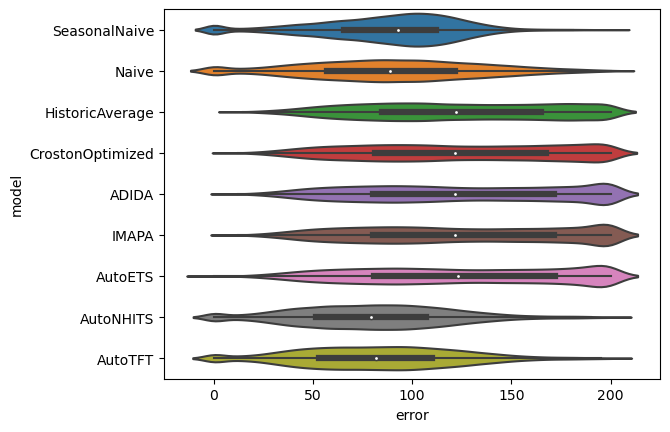

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

### Choose models for groups of series

Feature: 

* A unified dataframe with forecasts for all different models
* Easy Ensamble
* E.g. Average predictions
* Or MinMax (Choosing is ensembling)

<AxesSubplot: xlabel='n', ylabel='best_model'>

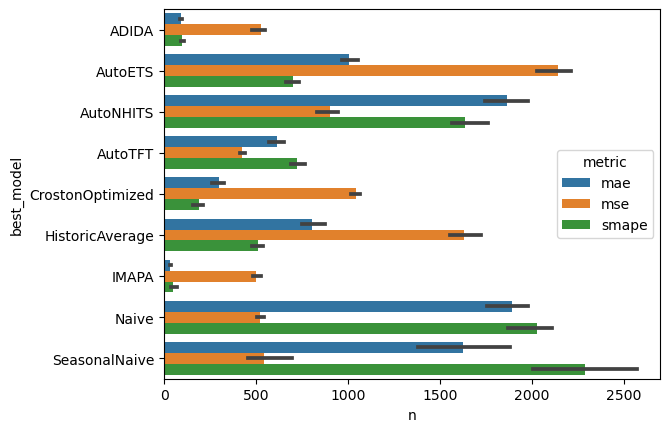

In [ ]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

### Et pluribus unum: an inclusive forecasting Pie.

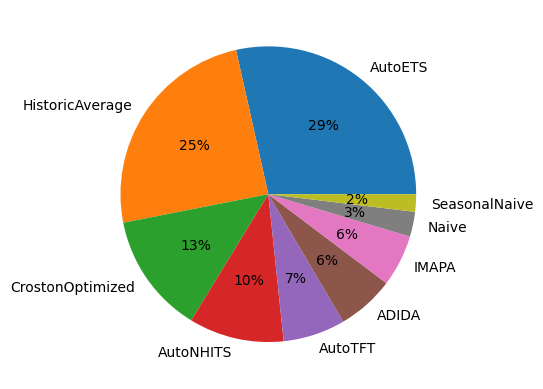

In [ ]:
# For the mse, calculate how many times a model wins
eval_series_df = evaluation_df.query('metric == "mse"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)
counts_series = eval_series_df.value_counts('best_model')
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

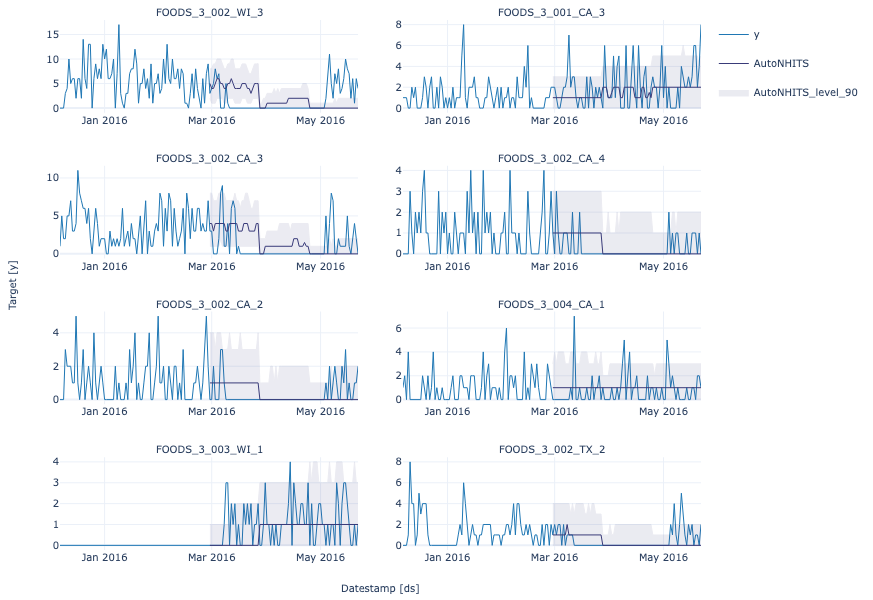

In [ ]:
sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=28 * 6, 
        models=['AutoNHITS'],
        unique_ids=eval_series_df.query('best_model == "AutoNHITS"').index[:8])

# Choose Forecasting method for different groups of series

In [ ]:
# Merge the best model per time series dataframe
# and filter the forecasts based on that dataframe
# for each time series
fcst_df = pd.melt(fcst_df.set_index('unique_id'), id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)
fcst_df = fcst_df.join(eval_series_df[['best_model']])
fcst_df[['model', 'pred-interval']] = fcst_df['model'].str.split('-', expand=True, n=1)
fcst_df = fcst_df.query('model == best_model')
fcst_df['name'] = [f'forecast-{x}' if x is not None else 'forecast' for x in fcst_df['pred-interval']]
fcst_df = pd.pivot_table(fcst_df, index=['unique_id', 'ds'], values=['forecast'], columns=['name']).droplevel(0, axis=1).reset_index()

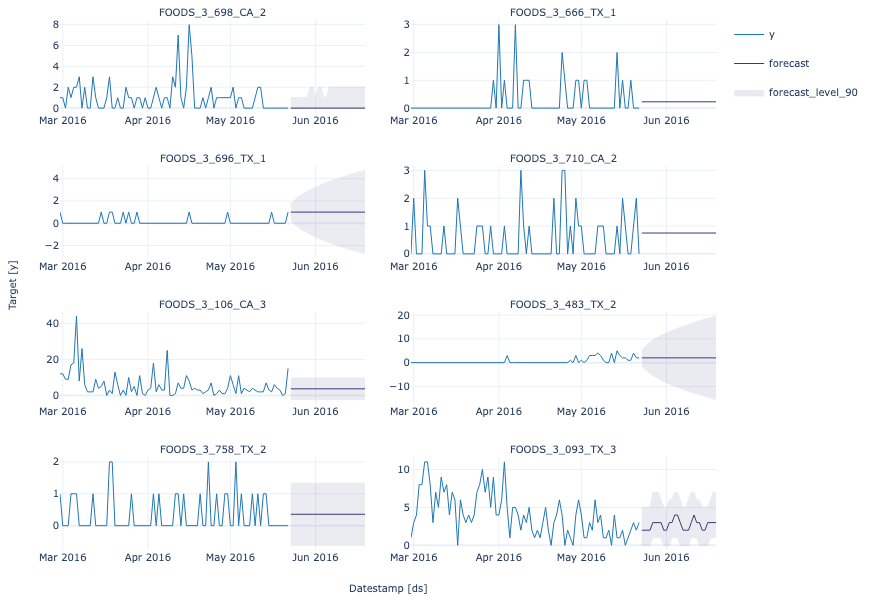

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

# Technical Debt

- Train the statistical models in the full dataset.
- Increase the number of `num_samples` in the neural auto models.
- Include other models such as `Theta`, `ARIMA`, `RNN`, `LSTM`, ...

# Further materials

- [Available Models StatsForecast](https://nixtla.github.io/statsforecast/examples/models_intro.html)
- [Available Models NeuralForecast](https://nixtla.github.io/neuralforecast/models.html)
- [Scalers and Loss Functions](https://nixtla.github.io/neuralforecast/losses.pytorch.html)
- [Getting Started NeuralForecast](https://nixtla.github.io/neuralforecast/examples/getting_started.html)
- [Hierarchical Reconciliation](https://nixtla.github.io/hierarchicalforecast/examples/tourismsmall.html)
- [Distributed ML Forecast (trees)](https://nixtla.github.io/mlforecast/docs/quick_start_distributed.html)
- [Using StatsForecast to train millions of time series](https://www.anyscale.com/blog/how-nixtla-uses-ray-to-accurately-predict-more-than-a-million-time-series)
- [Intermittent Demand Forecasting With Nixtla on Databricks](https://www.databricks.com/blog/2022/12/06/intermittent-demand-forecasting-nixtla-databricks.html)